<font size="6">Lesson 10: Convolutional Neural Networks</font>

Readings:
- [Deep learning, section 9](http://www.deeplearningbook.org/contents/convnets.html)
- [A Comprehensive Guide to Convolutional Neural Networks](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)
- [視覚野と畳み込みニューラルネットワーク](https://lp-tech.net/articles/frQNo)
- [Training a Classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

In [2]:
# import what you need
import warnings
warnings.filterwarnings("ignore")
from PIL import Image 
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
from IPython.display import clear_output
import cv2
from sklearn.metrics import accuracy_score
import torch.optim as optim

import sys
sys.path.append("/home/gonken2020/git/research/")
from implements_10.script_09 import *

--- 

<font size="5">Overviews</font>
1. Introduction
1. Implementation in PyTorch
1. Motivations
    1. Sparse interactions
    1. Parameter sharing
    1. Equivariant representations
1. Summary

--- 

# Introduction
In this notebook, I'm going to explain the motivations of (Convolutional Neural Networks)CNN 
and the implementation of it.
This notebook goes subject to the understanding of basic, computation procedure, pooling layer, and batch normalization.
First of all, I will introduce 3 main motivations and confirm it with a simple example.
And in the implementation section, I will show how to implement the CNN and compare it with FCC.


---

# Motivations
**Sparse interactions**, **parameter sharing** and **equivariant representations** are 
characteristics of the CNN which is important for the machine learning model to learn efficiently.

## Sparse interactions

## Parameter sharing

In [ ]:
def generate_edge_filter(vertical=True, device="cpu", nch=3):
    edge_filter = nn.Conv2d(nch, nch, 3, 1, 1)
    parameters = edge_filter.state_dict()
    bias = torch.zeros(parameters["bias"].shape)
    parameters["bias"] = bias
    weight = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
    if not vertical:
        weight = weight.T
    weight = np.tile(np.reshape(weight, (1,1,3,3)), (nch,nch,1,1))
    parameters["weight"] = torch.tensor(weight)
    edge_filter.load_state_dict(parameters)
    return edge_filter.to(device)

In [ ]:
img = Image.open("./implements_10/Minami_Hoshino.jpg").crop((132, 0, 900, 768)).resize((512, 512))
img = img.convert("RGB")
image = transforms.ToTensor()(img).view(1, 3, 512, 512)

In [ ]:
vertical_filter = generate_edge_filter(vertical=True)

In [ ]:
vertical_filter

In [ ]:
image_from_output(vertical_filter(image))[0]

## Equivariant representations

# Implementation
---
Ok, So let's go to the implementation of Convolutional Neural Networks(CNN). In this experiment, 
we're gonna compare the CNN with Fully Connected Networks by computing accuracy and checking the location invariance.

---

## Dataset

---
At first, I use the most popular image dataset, MNIST.
Originally, data in this dataset has a shape of 28x28, but it's resized to 32x32.
And data is rescaled in order to make their min and max be 0 and 1 respectively.

---

In [3]:
transform = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor()
    ])

In [4]:
batch_size = 128
trainset = torchvision.datasets.MNIST(root='./data',  train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.MNIST(root='./data',  train=False,  download=True,  transform=transform)
testloader = torch.utils.data.DataLoader(testset,  batch_size=len(testset), shuffle=False,  num_workers=2)

print("")
print(f"len_trainset : {len(trainset)}")
print(f"len_testset : {len(testset)}")


len_trainset : 60000
len_testset : 10000


---

This is the examples of data.

---

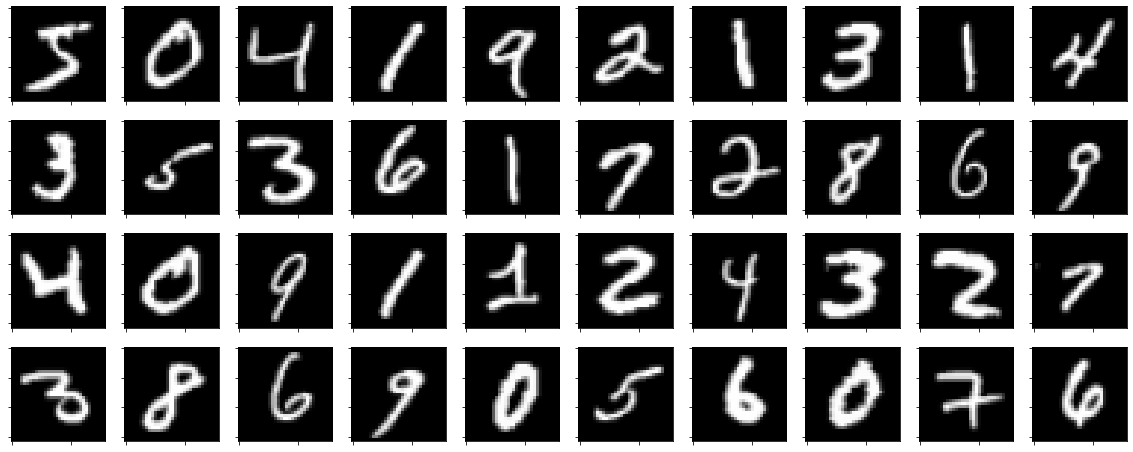

In [5]:
fig = plt.figure(figsize=(20, 8))
for i in range(40):
    image = image_from_output(trainset[i][0].view(1, 1, 32, 32))[0]
    ax = fig.add_subplot(4, 10, i+1)
    ax.imshow(image)
    ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)

## Model
---

As you know, CNN is composed of some convolutional blocks and some fully connected layers(fc),
where the convolutional block is made up by a convolutional layer, a pooling layer, and an activation fuction.
In this example, CNN is comprised of 3 convolutional blocks and 1 fc.

---

As for the implementation of basic CNN, you need to set some hyperparameters as follows

- for convolutional layer
    - \# of input channels
    - \# of output channels (filters)
    - kernel size (filter size)
    - stride size
    - padding size
- for pooling layer
    - kernel size (filter size)
    - stride size
- for fc layer
    - input feature size
    - output feature size
    
---
    
In general, h-parameters in the convolutional layer is set to make shape of its output equal to that of input, 
and data is downsampled by just setting h-parameter in the pooling layer to integers apart from "1".
the output size is solved by the expression between the input data and the convolutional layer below.
$$
\left(\left\lfloor \frac{n+2p-f}{s} \right\rfloor + 1,\quad \left\lfloor \frac{n+2p-f}{s} \right\rfloor + 1\right)
$$
where ($n$ x $n$) is the shape of input data, ($f$ x $f$) is the shape of filter, and ($s$ x $s$) is the stride.

---

In [6]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)

In [49]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        layers = []
        layers.append(nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=1, padding=1))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        
        layers.append(nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, stride=1, padding=1))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        
        layers.append(nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, stride=1, padding=1))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        
        layers.append(Flatten())
        layers.append(nn.Linear(in_features=64*4*4, out_features=10))
        
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.layers(x)

In [50]:
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        layers = []
        layers.append(Flatten())
        layers.append(nn.Linear(1 * 32 * 32, 120))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(120, 84))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(84, 32))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(32, 10))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [51]:
cnn = CNN()
fcn = FCN()

print("")
param_num = 0
for param in list(cnn.state_dict().keys()):
    num = cnn.state_dict()[param].flatten().shape[0]
    print(param, num)
    param_num += num
print("whole", param_num)
print("--------------------------")

param_num = 0
for param in list(fcn.state_dict().keys()):
    num = fcn.state_dict()[param].flatten().shape[0]
    print(param, num)
    param_num += num
print("whole", param_num)


layers.0.weight 36
layers.0.bias 4
layers.3.weight 576
layers.3.bias 16
layers.6.weight 9216
layers.6.bias 64
layers.10.weight 10240
layers.10.bias 10
whole 20162
--------------------------
layers.1.weight 122880
layers.1.bias 120
layers.3.weight 10080
layers.3.bias 84
layers.5.weight 2688
layers.5.bias 32
layers.7.weight 320
layers.7.bias 10
whole 136214


---

Even though they have the exact same depth of the model.
FCN has over 30 times more parameters than CNN does. 

---

## Training 
---
Let's train your model !

---

### Preparation
---

For the sake of simplisity, I fisrt implement the training function and the test function.
Let's take a look at it.

the variables are defined as follows: 
- ***data***: this consists of image data and the label in the form of *(image, label)*
- ***x***: image data, shape: *(batch_size, 1, 32, 32)* 
- ***label***: the label of the image data
---

In [52]:
def do_train(net, optimizer, scheduler, criterion, trainloader, visualize=True, save=False, save_path=""):
    net.train() # make the model aware of which mode it needs to be
    losses_epoch = [] # losses respect to epoch
    for epoch in range(epoch_num):
        losses = [] 
        for itr, data in enumerate(trainloader): # get data from trainloader
            x = data[0].to(device) 
            label = data[1].to(device)

            net.zero_grad() # initialize the gradient information in the model
            y = F.softmax(net(x)) # prediction
            loss = criterion(y, label) # get the loss regarding the prediction
            loss.backward() # backpropadate through the model
            optimizer.step() # update the model

            losses.append(cuda_to_numpy(loss))
        losses_epoch.append(np.mean(np.array(losses)))
        clear_output(wait=True)
        print(epoch+1)
        if visualize:
            plt.plot(losses_epoch)
            plt.show()
        scheduler.step()
    if save:
        torch.save(net.state_dict(), save_path)

In [53]:
def do_test(net, testloader):
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = F.softmax(net(images))
    return cuda_to_numpy(outputs), cuda_to_numpy(images), cuda_to_numpy(labels)

In [54]:
epoch_num = 100
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"

### Convolutional Neural Networks
---
To begin with the training of CNN, let's use the CNN model that we implemented,
and define some algorithms for training.

---

In [66]:
cnn = CNN() # call the CNN model
cnn = cnn.to(device) # use GPU or cpu
cnn.apply(weights_init) # initialize the weight
cnn_optim = optim.SGD(cnn.parameters(), lr=0.1, momentum=0.9) # call the optimizer. For now, let's use SGD.
cnn_sche = optim.lr_scheduler.ExponentialLR(cnn_optim, gamma=0.95)
criterion = nn.CrossEntropyLoss() # Loss function

---
Let's train the model

---

100


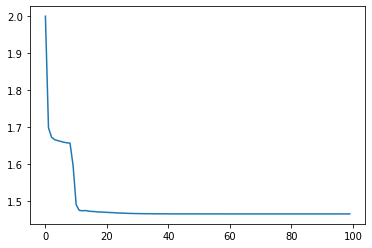

In [67]:
do_train(cnn, cnn_optim, cnn_sche, criterion, trainloader, True, False, f"./implements_10/parameters/cnn_parameters.pth")

---
Since it's lengthy process, I've already completed the training and saved the parameters of it. Let's call it with the code below.

---

In [68]:
load = True
if load:
    cnn_path = f"./implements_10/parameters/cnn_parameters.pth"
    cnn_model = torch.load(cnn_path)
    cnn.load_state_dict(cnn_model)

---
This is the test process and the computation of accuracy.

---

In [148]:
cnn_outputs, cnn_inputs, cnn_labels = do_test(cnn, testloader)
accuracy_score(cnn_labels, np.argmax(cnn_outputs, axis=1))

0.9902

---
Cool!

---

### Fully Connected Networks
Next, let's train the model consists of fc layers.

In [70]:
fcn = FCN()
fcn = fcn.to(device)
fcn.apply(weights_init)
fcn_optim = optim.SGD(fcn.parameters(), lr=0.1, momentum=0.9)
fcn_sche = optim.lr_scheduler.ExponentialLR(fcn_optim, gamma=0.95)
criterion = nn.CrossEntropyLoss()

100


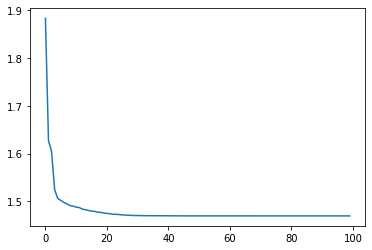

In [71]:
do_train(fcn, fcn_optim, fcn_sche, criterion, trainloader, True, False, f"./implements_10/parameters/fcn_parameters.pth")

In [72]:
load = True
if load:
    fcn_path = f"./implements_10/parameters/fcn_parameters.pth"
    fcn_model = torch.load(fcn_path)
    fcn.load_state_dict(fcn_model)

In [73]:
fcn_outputs, fcn_inputs, fcn_labels = do_test(fcn, testloader)
accuracy_score(fcn_labels, np.argmax(fcn_outputs, axis=1))

0.9802

---

Wow! This model also worked very well.

---

## Equivalent representations
---
Next, I'm gonna talk about the example of one of the motivations, equivalent representations, I mentioned.
I observed the feature map of each layer when I shifted the input image to left, right, up, or down.

---

input data


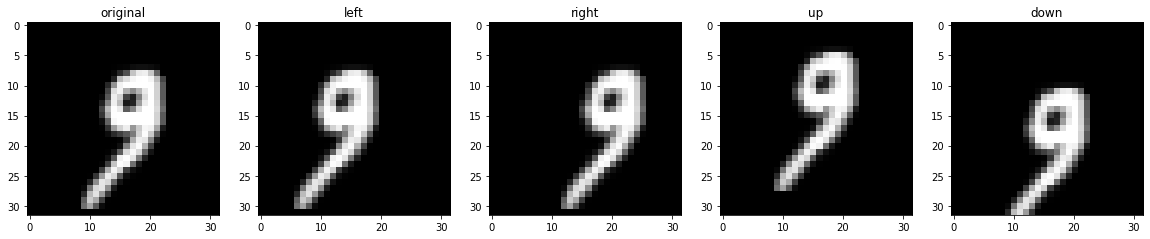

Conv2d


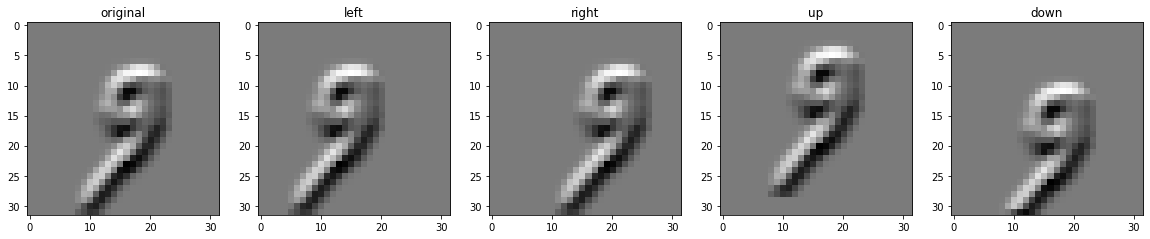

ReLU


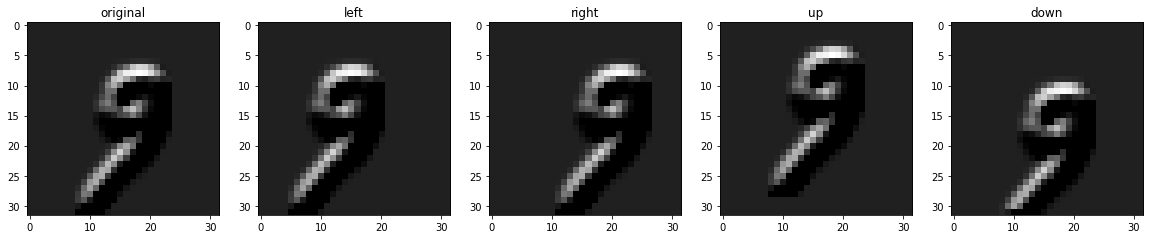

MaxPool2d


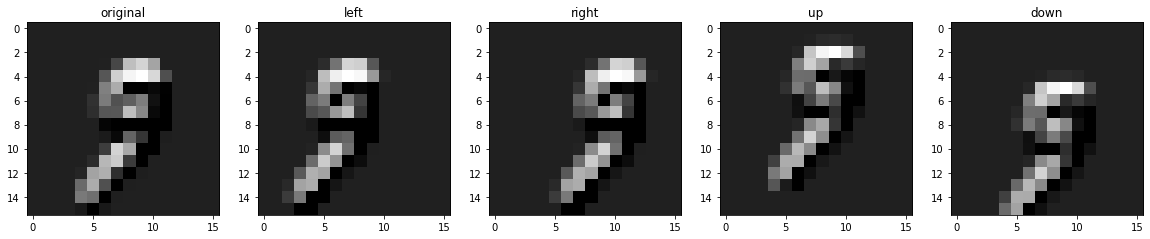

Conv2d


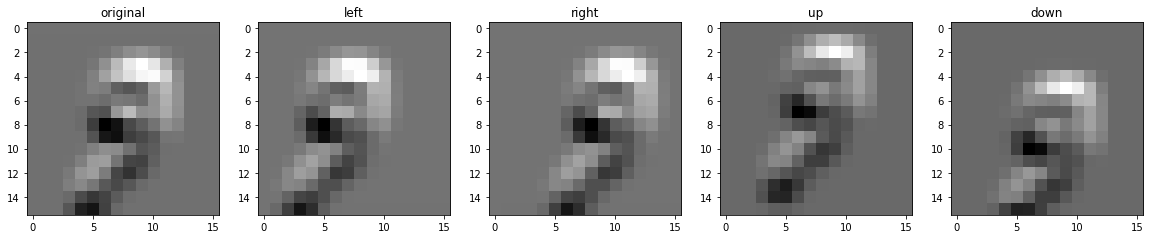

ReLU


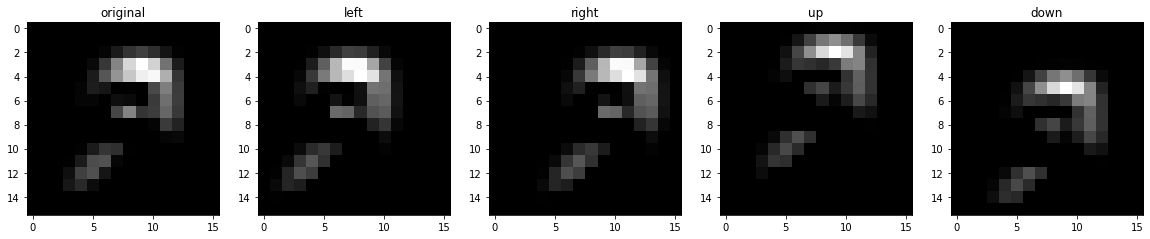

MaxPool2d


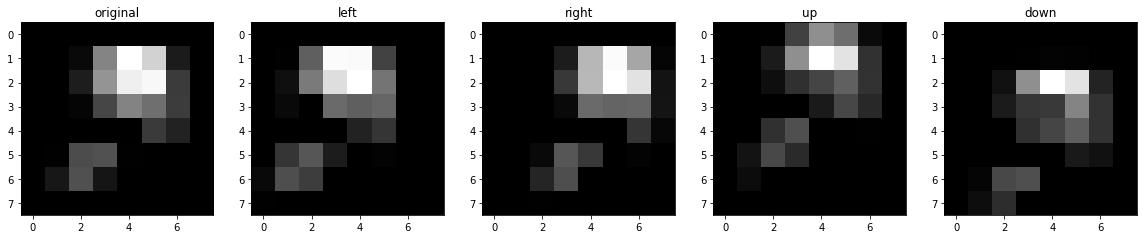

Conv2d


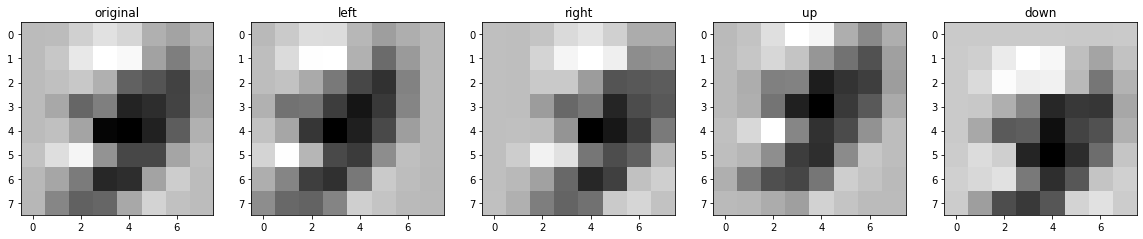

ReLU


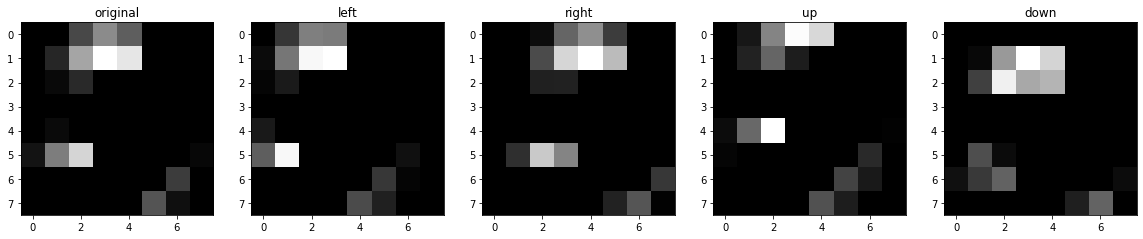

MaxPool2d


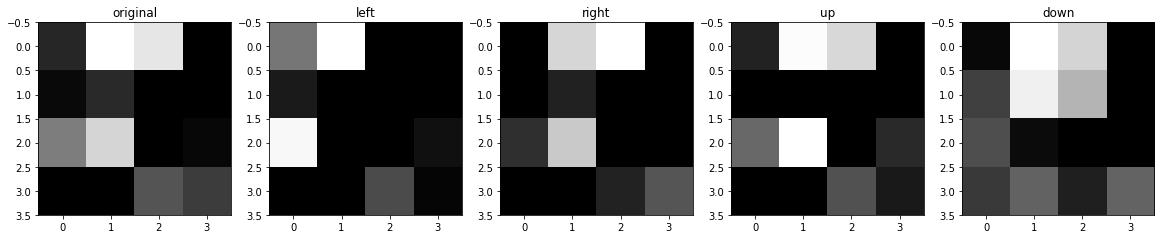

In [159]:
num = 1000
type_list = ["original", "left", "right", "up", "down"]
img = testset[num][0].view(1, 1, 32, 32)
new_list = move_image(img, transform, 3).to(device)

new = new_list
model = cnn.layers

print("input data")
fig = plt.figure(figsize=(20, 4))
for i in range(5):
    ax = fig.add_subplot(1, 5, i+1)
    ax.imshow(image_from_output(new[i:i+1,0:1,:,:])[0])
    ax.set_title(type_list[i])
plt.show()

for layer in model[:-2]:
    print(str(layer).split("(")[0])
    fig = plt.figure(figsize=(20, 4))
    new = layer(new)

    for i in range(5):
        ax = fig.add_subplot(1, 5, i+1)
        ax.imshow(image_from_output(new[i:i+1,0:1,:,:])[0])
        ax.set_title(type_list[i])
    plt.show()

---
As you can observe, as the input image is moved, the feature map is also shifted.
I will explain why It's important for the model in next section.

---

## Location invariance
---
As a result, both CNN and FCN worked very well and the accuracies are almost the same.
So that is the memory kindness the only advantage ? 

***No!***, location invariance is also essencial for CNN thanks to ***sparse interactions***, ***parameter sharing***,
and ***equivalent representations*** I mentioned at the beginning.

---
I observed the output when I shifted the image to left, right, up, or down.

---

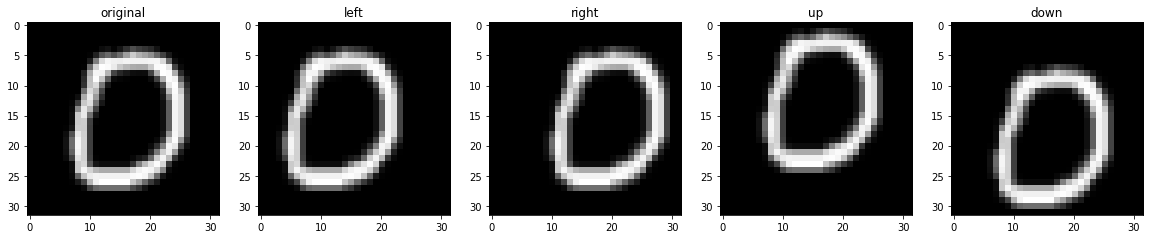

In [104]:
num = 10
type_list = ["original", "left", "right", "up", "down"]
img = testset[num][0].view(1, 1, 32, 32)
new_list = move_image(img, transform, 3).to(device)

fig = plt.figure(figsize=(20, 5))
for i in range(5):
    ax = fig.add_subplot(1, 5, i+1)
    ax.imshow(image_from_output(new_list[i:i+1])[0])
    ax.set_title(type_list[i])

---
Let's input them into the model we trained before.

***deviation from original data***: the absolute value of the error between the original output and the modified output.

---

CNN
    prediction                     :[0 0 0 0 0]
    deviation from original data   :0.0007467521936632693
FCN
    prediction                     :[0 2 6 6 0]
    deviation from original data   :5.988245010375977


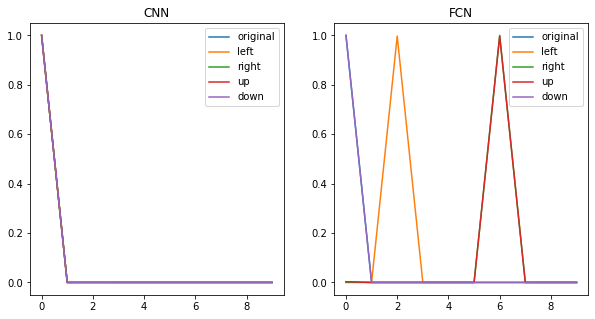

In [105]:
fig = plt.figure(figsize=(10, 5))
cnn.eval()
fcn.eval()
for j in range(2):
    model = [cnn, fcn][j]
    model_name = str(model).split("(")[0]
    print(model_name)
    ax = fig.add_subplot(1, 2, j+1)
    a = cuda_to_numpy(F.softmax(model(new_list)))
#     a = cuda_to_numpy(model(new_list))
    print(f"    prediction                     :{np.argmax(a, axis=1)}")
    print(f"    deviation from original data   :{np.sum(np.abs(a[0:1] - a[1:]))}")
    for i in range(5):
        ax.plot(a[i,:], label=type_list[i])
    plt.legend()
    ax.set_title(model_name)

---
Apparantly, the outputs from the CNN are insusceptible to the slightly change of the location.

---

# Summary
I have demonstraited the motivations and the implementation of Convolutional Neural Networks.
It's able to train efficiently thanks to ***sparse interactions***, ***parameter sharing***,
and ***equivalent representations***.
I've just introduced the basis of CNN.
There are a lot of applications or algorithms which includes U-Net, VGG16, and so on.